In [105]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import cv2 
from PIL import Image
from matplotlib import pyplot as plt 

In [2]:
from tqdm import tqdm

### ici on lit les fichiers .tiff qui se trouve dans le chemin 'data/CALSPAR_init_Mines/'

In [3]:
Old_Im=[]
Finals=[]
for i in range(1,10):
    final = np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_binary_00"+str(i)+".tiff"))
    start= np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_greyscale_00"+str(i)+".tiff"))
    Finals.append(final)
    Old_Im.append(cv2.fastNlMeansDenoising(start, None, 20, 7, 21))
for i in range(10,100):
    final = np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_binary_0"+str(i)+".tiff"))
    start= np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_greyscale_0"+str(i)+".tiff"))
    Finals.append(final)
    Old_Im.append(cv2.fastNlMeansDenoising(start, None, 20, 7, 21))
for i in tqdm(range(100,951)):
    final = np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_binary_"+str(i)+".tiff"))
    start= np.array(Image.open("data/CALSPAR_init_Mines/crystal_825x300x950_8bits_greyscale_"+str(i)+".tiff"))
    Finals.append(final)
    Old_Im.append(cv2.fastNlMeansDenoising(start, None, 20, 7, 21))

100%|██████████| 851/851 [07:25<00:00,  1.91it/s]


In [4]:
def histogramme(img):
    histo=[0]*256
    for line in img:
        for pixel in line:
            histo[pixel]+=1
    plt.bar(range(256),histo)
    plt.show()
    
def histo(img):
    histo=[0]*256
    for line in img:
        for pixel in line:
            histo[pixel]+=1
    return np.array(histo)
def seg(img):
    hstg=histo(img)
    somme=sum(hstg)
    s=0
    for i,c in enumerate(hstg):
        s+=(i+1)*c
    s=s/somme
    return s

def image_segmente(img,mid):
    n,m=len(img),len(img[0])
    
    r=np.zeros((n,m))
    for i in range(n):
        for j in range(m):
            if img[i][j]>=mid:
                r[i][j]=255
            else:
                r[i][j]=0
    return r

In [5]:
def seg_detect(img_gray,img_seg):
    frontier=0
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j]==0:
                if img_gray[i][j]>frontier:
                    frontier=img_gray[i][j]
    return frontier

### seg_detect permet de trouver la bonne valeur de la frontiere qu'on utilisera dans le machine learning

In [6]:
seg_detect(Old_Im[0],Finals[0])

146

#### Ici pour l'image 0 notre programme doit renvoyer 146 optimalement

In [7]:
seg(Old_Im[0])

91.27584242424243

#### L'algorithme normal rend 91 ce qui donne de bon resultats mais n'est pas optimal

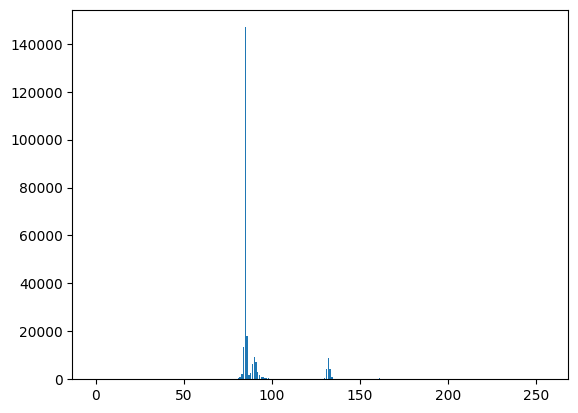

In [8]:
histogramme(Old_Im[0])

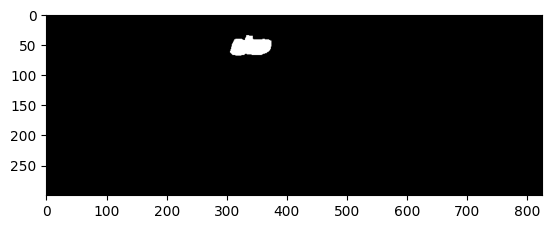

In [9]:
plt.imshow(Finals[0],cmap='gray')

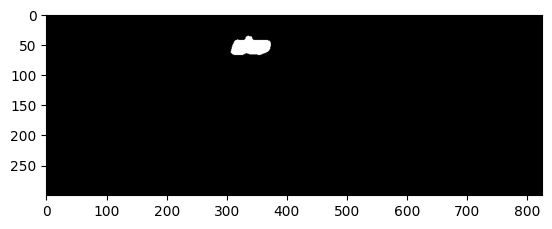

In [10]:
plt.imshow(image_segmente(Old_Im[0],146),cmap='gray')

### la partie qui suit se concentre sur la preparation des donnees pour le machine learning

In [11]:
data=[]
y=[]
for i in tqdm(range(950)):
    data.append(histo(Old_Im[i]))
    y.append(seg_detect(Old_Im[i],Finals[i]))

100%|██████████| 950/950 [14:47<00:00,  1.07it/s]


In [12]:
tor_data=torch.tensor(data,dtype=torch.float32)
tor_y=torch.tensor(y,dtype=torch.float32)

C:\Users\dell\AppData\Local\Temp\ipykernel_19388\4119166571.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  tor_data=torch.tensor(data,dtype=torch.float32)


In [13]:
tor_y=tor_y/255

In [14]:
tor_data=tor_data/255

In [107]:
X=[Old_Im[j][30*i:30*(i+1)][30*i:30*(i+1)] for i in range(20) for j in range(100)]

In [110]:
len(X)

2000

#### on definit maintenant le reseau de neuronnes : 2 couches de 256 neuronnes aevc une sortie

In [91]:
n_input,n_hidden,n_out=256,256,1
model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, 1),
                      )
batch_size, learning_rate =950,0.005
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### on entraine ensuite ce reseau

In [92]:
losses = []
for epoch in tqdm(range(5000)):
    pred_y = model(tor_data)
    loss = loss_function(pred_y, tor_y)
    losses.append(loss.item())
    l2_lambda = 0.1
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
 
    loss = loss + l2_lambda * l2_norm
    model.zero_grad()
    loss.backward()

    optimizer.step()

100%|██████████| 5000/5000 [00:58<00:00, 86.00it/s]


### ci dessous, la presicion stagne apres un certain moment

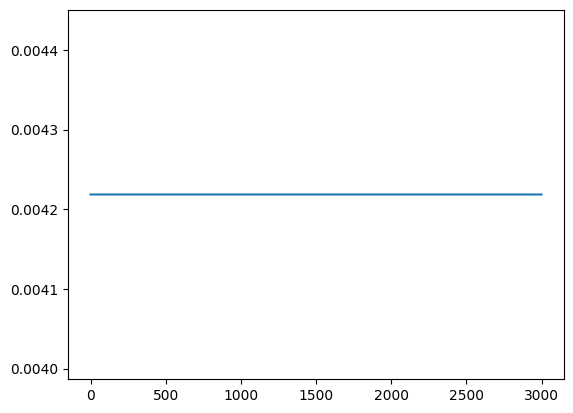

In [94]:
plt.plot(losses[2000:])

In [95]:
float(model(torch.tensor(histo(Old_Im[100]),dtype=torch.float32)))*255

134.31224405765533

### le reseau renvoie 134 pour une image ou il faut renvoyer 183

In [96]:
seg_detect(Old_Im[100],Finals[100])

183

In [97]:
errors=[]
NEW=[]
for i in tqdm(range(150)):
    mid=float(model(torch.tensor(histo(Old_Im[i]),dtype=torch.float32)))*255
    new_im=image_segmente(Old_Im[i],mid)
    NEW.append(new_im)
    errors.append(np.sum(np.abs(new_im- Finals[i]*255 )))

100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


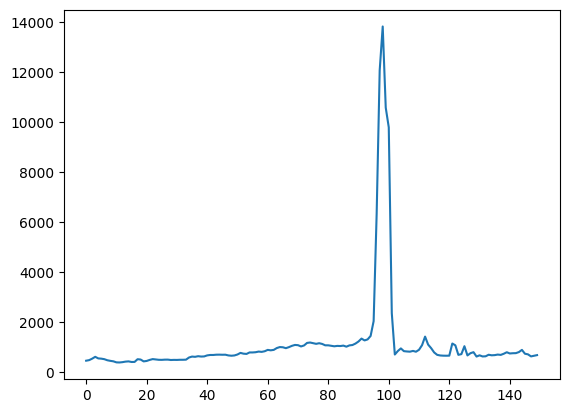

In [98]:
plt.plot(np.array(errors)//255)

### ci dessus, le nombre de pixels erronees dans l'image, seul les images autour de 100 sont un problemes

In [99]:
np.sum(np.abs(new_im- Finals[i]))

12784491.0

In [100]:
print(np.array(errors[0])//255)

448.0


### Les images mal segmentees

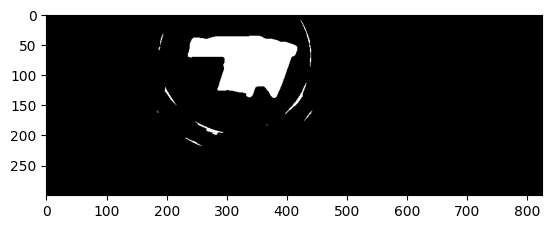

In [101]:
plt.imshow(NEW[80],cmap='gray')

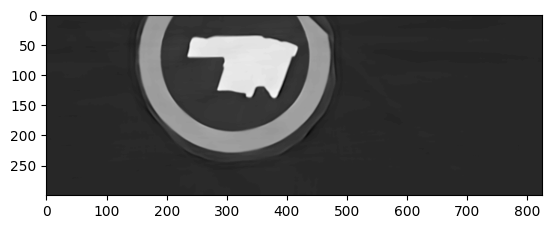

In [102]:
plt.imshow(Old_Im[80],cmap='gray')

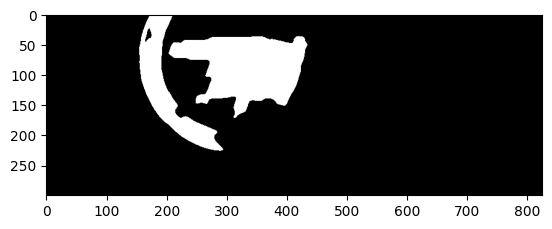

In [103]:
plt.imshow(NEW[100],cmap='gray')

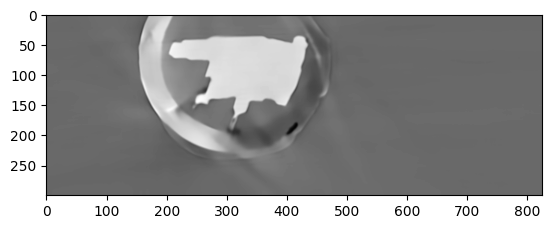

In [104]:
plt.imshow(Old_Im[100],cmap='gray')

In [79]:
float(model(torch.tensor(histo(Old_Im[20]),dtype=torch.float32)))*255

203.4746128320694

In [38]:
seg_detect(Old_Im[0],Finals[0])

146

In [39]:
import numpy as np 
import cv2 
from matplotlib import pyplot as plt 

## On utilise notre resaeu sur un autre crystal

In [40]:
fichier = np.fromfile("F2.raw", np.uint8)

In [41]:
fichier = fichier.reshape((1080, 600, 1050))

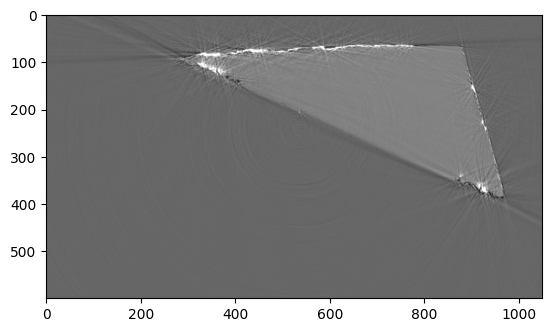

In [42]:
plt.imshow(fichier[100],cmap='gray')

In [45]:
m1=float(model(torch.tensor(histo(fichier[100]),dtype=torch.float32)))*255

In [46]:
new_im=image_segmente(fichier[100],m1)

### il ya beaucoup de surapprentissage

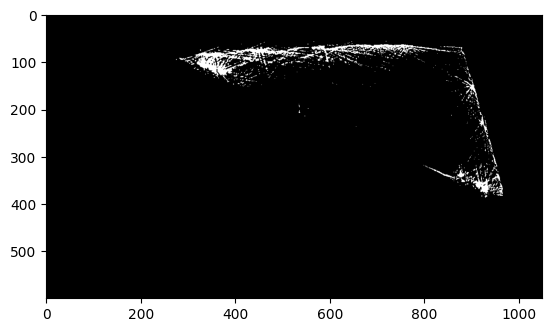

In [47]:
plt.imshow(new_im,cmap='gray')

1


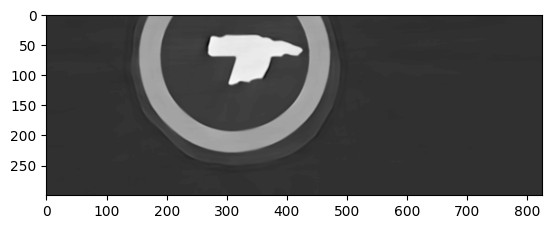

In [121]:
plt.imshow(Old_Im[50],cmap='gray')

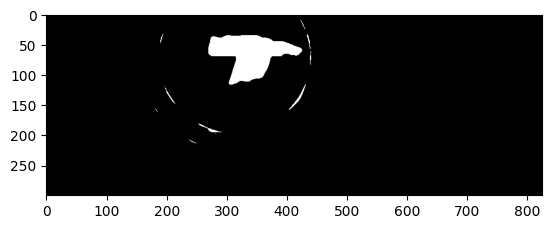

In [125]:
mid=float(model(torch.tensor(histo(Old_Im[50]),dtype=torch.float32)))*255
new_im=image_segmente(Old_Im[50],mid)
plt.imshow(new_im,cmap='gray')